## Query GPT-4 for name and analysis using a toy example

#### This uses an improved version of the original prompt that includes instructions to generate an LLM Confidence Score.

#### The prompt also includes an example analysis to help the LLM in its task.

#### The LLM Score has its own column in the output TSV file.

#### The JSON config file is updated to use "GPT-4_1106-preview" build.

Update 12-21-2023

new available models through api: https://api.llm.ideker.ucsd.edu/api/chat

available models:

| NAME           | ID           | SIZE   |
|----------------|--------------|--------|
| llama2:70b     | c3a7af098300 | 38 GB  |
| llama2:7b      | fe938a131f40 | 3.8 GB |
| llama2:latest  | fe938a131f40 | 3.8 GB |
| mistral:7b     | 4d9f4b269c33 | 4.1 GB |
| mixtral:latest | 99a9202f8a7a | 26 GB  |

In [1]:
import pandas as pd
import json 
from utils.openai_query import openai_chat
from utils.prompt_factory import make_user_prompt_with_score
from utils.server_model_query import server_model_chat
from utils.llm_analysis_utils import process_analysis, save_progress
from tqdm import tqdm
import openai
import os
import logging
%load_ext autoreload
%autoreload 2


In [2]:
## load variables
initialize = True # if True, then initialize the input table with llm names, analysis and score to None 
# Replace with your actual values
config_file = './jsonFiles/toyexample_mistral.json'  # replace with your actual config file 
input_file = 'data/GO_term_analysis/toy_example_contaminated.csv' # replace with your actual input file
input_sep = ','  # replace with the separator
set_index = 'GO'  # replace with your column name that you want to set as index or None
gene_column = 'Genes'  # replace with your actual column name for the gene list
gene_sep = ' '  # replace with your actual separator
gene_features = None  # replace with your path to the gene features or None if you don't want to include in the prompt
direct = False # if True, then the prompt will be a direct sentence asking for a name and analysis from the gene set, otherwise default or customized prompt
out_file = 'data/GO_term_analysis/1219_mistral_LLM_processed_toy_example'  # replace with your actual output file name

customized_prompt = False # if True, then the prompt will be the custom prompt, if False, then the prompt will use default

# load the config file
with open(config_file) as json_file:
    config = json.load(json_file)

if customized_prompt:
    # make sure the file exist 
    if os.path.isfile(config['CUSTOM_PROMPT_FILE']):
        with open(config['CUSTOM_PROMPT_FILE'], 'r') as f: # replace with your actual customized prompt file
            customized_prompt = f.read()
            assert len(customized_prompt) > 1, "Customized prompt is empty"
    else:
        print("Customized prompt file does not exist")
        customized_prompt = None
else:
    customized_prompt = None

# Load OpenAI key, context, and model used 
openai.api_key = os.environ["OPENAI_API_KEY"]

context = config['CONTEXT']
model = config['MODEL']
temperature = config['TEMP']
max_tokens = config['MAX_TOKENS']
if model.startswith('gpt'):
    rate_per_token = config['RATE_PER_TOKEN']
    DOLLAR_LIMIT = config['DOLLAR_LIMIT']
LOG_FILE = config['LOG_NAME']+'_log.json'

SEED = 42
column_prefix = model.split('-')[0]

In [3]:
def main(df):

    logging.basicConfig(filename=f'{out_file}.log', level=logging.INFO)

    i = 0 #used for track progress and saving the file
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        #only process None rows 
        if row[f'{column_prefix} Analysis'] is not None:
            continue
        
        gene_data = row[gene_column]
        # if gene_data is not a string, then skip
        if type(gene_data) != str:
            
            logging.warning(f'Gene set {idx} is not a string, skipping')
            continue
        genes = gene_data.split(gene_sep)
        
        if len(genes) >1000:
            logging.warning(f'Gene set {idx} is too big, skipping')
            continue

        try:
            prompt = make_user_prompt_with_score(genes)
            finger_print = None
            if model.startswith('gpt'):
                analysis, finger_print = openai_chat(context, prompt, model, temperature, max_tokens, rate_per_token, LOG_FILE, DOLLAR_LIMIT, SEED)
            else:
                analysis= server_model_chat(context, prompt, model, max_tokens, temperature, LOG_FILE, SEED)

            
            if analysis:
                llm_name, llm_score, llm_analysis = process_analysis(analysis)
                df.loc[idx, f'{column_prefix} Name'] = llm_name
                df.loc[idx, f'{column_prefix} Analysis'] = llm_analysis
                df.loc[idx, f'{column_prefix} Score'] = float(llm_score)

                # Log success with fingerprint
                logging.info(f'Success for {idx} {column_prefix}.')
                if finger_print:
                    logging.info(f'GPT_Fingerprint for {idx}: {finger_print}')
                

        except Exception as e:

            logging.error(f'Error for {idx}: {e}')
            continue
        i += 1
        if i % 10 == 0:
            df.to_csv(f'{out_file}.tsv', sep='\t', index=True)
            print(f"Saved progress for {i} genesets")
    

In [4]:
#Define your own loop for running the pipeline
## 12-18-2023: this loop is for run the default gene set and the contaminated gene sets 
## can modify this loop for different models or only run on default gene set

if __name__ == "__main__":
    
    df = pd.read_csv(input_file, sep=input_sep, index_col=set_index)
    
    column_prefix = model.split('-')[0] + '_default' #this is default
    
    if initialize:
        # initialize the input file with llm names, analysis and score to None
        df[f'{column_prefix} Name'] = None
        df[f'{column_prefix} Analysis'] = None
        df[f'{column_prefix} Score'] = None
    main(df)  ## run with the real set 
    
    ## run the pipeline for contaiminated gene sets 
    contaminated_columns = [col for col in df.columns if col.endswith('contaminated_Genes')]
    # print(contaminated_columns)
    for col in contaminated_columns:
        gene_column = col ## Note need to change the gene_column to the contaminated column
        contam_prefix = '_'.join(col.split('_')[0:2])
        column_prefix = model.split('-')[0] + '_' +contam_prefix
        print(column_prefix)

        if initialize:
            # initialize the input file with llm names, analysis and score to None
            df[f'{column_prefix} Name'] = None
            df[f'{column_prefix} Analysis'] = None
            df[f'{column_prefix} Score'] = None
        main(df)
    # df.head()


100%|██████████| 10/10 [01:59<00:00, 11.97s/it]


Saved progress for 10 genesets
mistral:7b_50perc_contaminated


100%|██████████| 10/10 [01:53<00:00, 11.32s/it]


Saved progress for 10 genesets
mistral:7b_100perc_contaminated


100%|██████████| 10/10 [02:05<00:00, 12.59s/it]

Saved progress for 10 genesets


In [12]:
import pandas as pd 
score_df = pd.read_csv(f'{out_file}.tsv', sep = '\t')
score_df

,GO,Genes,Gene_Count,Term_Description,50perc_contaminated_Genes,100perc_contaminated_Genes,LLM Name,LLM Analysis,LLM Score,50perc_contaminated_LLM Name,50perc_contaminated_LLM Analysis,50perc_contaminated_LLM Score,100perc_contaminated_LLM Name,100perc_contaminated_LLM Analysis,100perc_contaminated_LLM Score
0,GO:0032385,LDLRAP1 SCP2D1 ANXA2 SCP2,4,positive regulation of intracellular cholester...,LDLRAP1 SCP2 TRIM45 NME5,HMGA2 MID2 HSFX2 FOXP4,Lipid Metabolism and Intracellular Cholesterol...,1. LDLRAP1 (Low-Density Lipoprotein Receptor A...,0.92,Lipid Metabolism and Intracellular Trafficking,1. LDLRAP1 (Low-Density Lipoprotein Receptor A...,0.85,Regulation of Gene Expression and Developmenta...,1. HMGA2 (High Mobility Group AT-hook 2) is a ...,0.75
1,GO:0002468,NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 ...,15,dendritic cell antigen processing and presenta...,CD68 HLA-DRB3 CCL19 CCL21 HLA-DRA NOD2 THBS1 T...,JAG1 LTK ARL17A SLCO4A1 PLEKHO2 NDUFS5 ZC3H12D...,Innate and Adaptive Immune Response Coordination,1. NOD1 and NOD2 are intracellular pattern rec...,0.92,Immune Response and Antigen Presentation,1. CD68 is a glycoprotein highly expressed by ...,0.85,System of unrelated proteins,1. JAG1 is a ligand for multiple Notch recepto...,0.00
2,GO:0033683,OGG1 ERCC5 XPA ERCC4 NTHL1,5,"nucleotide-excision repair, DNA incision",XPA NTHL1 NAA11 SCD5 CDCA8,MBTPS2 PRCD BUB3 SLC13A1 FADS2,DNA Repair and Maintenance,1. OGG1 (8-oxoguanine DNA glycosylase) is invo...,0.98,DNA Repair and Cell Cycle Progression,"1. XPA (Xeroderma Pigmentosum, complementation...",0.85,Lipid Metabolism and Cell Cycle Regulation,1. MBTPS2 (Membrane-bound transcription factor...,0.75
3,GO:0035672,SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 C...,15,oligopeptide transmembrane transport,GJA1 SLC15A4 SLC15A1 CDH17 SLC25A39 SLC26A6 SL...,DEFB113 GLMN CELA2B SIGLEC7 RIGI CCL3L3 DEFB11...,Ion Transport and Cellular Homeostasis,1. SLC7A11 is a component of the cystine/gluta...,0.85,System of unrelated proteins,"1. GJA1, also known as Connexin 43, is a compo...",0.00,System of unrelated proteins,1. DEFB113 and DEFB115 are members of the beta...,0.00
4,GO:0048023,OPN3 CDH3 ATP7A APPL1 ASIP RAB38 ZEB2 TYRP1 GIPC1,9,positive regulation of melanin biosynthetic pr...,TYRP1 CDH3 OPN3 RAB38 FGFRL1 ZNF429 DUS3L CTSK...,WEE2 STIM1 EXOC4 MYO15A GLIPR1L1 ATAD3A CDCA5 ...,Melanogenesis and Intracellular Copper Transport,"1. OPN3, also known as Opsin 3, is a G protein...",0.85,Melanogenesis and Pigment Cell Biology,1. TYRP1 (Tyrosinase-related protein 1) is a m...,0.85,System of unrelated proteins,1. WEE2 is a protein kinase that plays a cruci...,0.00
5,GO:0044029,ZMPSTE24 NIBAN2 PIK3CA,3,hypomethylation of CpG island,ZMPSTE24 NLN PRPF6,BAP1 THAP11 TFAP4,Protein processing and cell survival signaling,1. ZMPSTE24 is a zinc metalloproteinase involv...,0.85,Pre-mRNA Splicing and Protein Maturation,1. ZMPSTE24 is a zinc metalloproteinase involv...,0.85,Regulation of Gene Expression and Cell Cycle,1. BAP1 (BRCA1 Associated Protein-1) is a deub...,0.85
6,GO:0048014,TEK ANGPT1 SVEP1 ANGPT2,4,Tie signaling pathway,SVEP1 TEK USF3 SUPT3H,CLEC19A AOC3 LRFN3 PITX2,Angiogenesis and Vascular Development,"1. TEK, also known as TIE2, is a receptor tyro...",0.92,System of unrelated proteins,"1. SVEP1 (Sushi, Von Willebrand Factor Type A,...",0.00,System of unrelated proteins,1. CLEC19A (C-type lectin domain family 19 mem...,0.00
7,GO:0010845,PRDM9 PRDM7 RAD51AP1 UBE2B,4,positive regulation of reciprocal meiotic reco...,PRDM7 UBE2B PSMC5 TMEM256,PLIN2 LRRC41 HSD17B12 BLOC1S3,Meiotic Chromosomal Dynamics and Genetic Recom...,1. PRDM9 is a histone methyltransferase that p...,0.85,Protein Modification and Degradation Pathway R...,1. PRDM7 (PR domain containing 7) is a member ...,0.85,Lipid Metabolism and Storage,"1. PLIN2, also known as Adipose Differentiatio...",0.85
8,GO:0050434,MDFIC RSF1 DHX9,3,positive regulation of viral transcription,MDFIC USF3 TAF13,FAXDC2 PNMT TRMO,Chromatin remodeling and RN

/tmp/ipykernel_3357596/1712979539.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Gene Count')


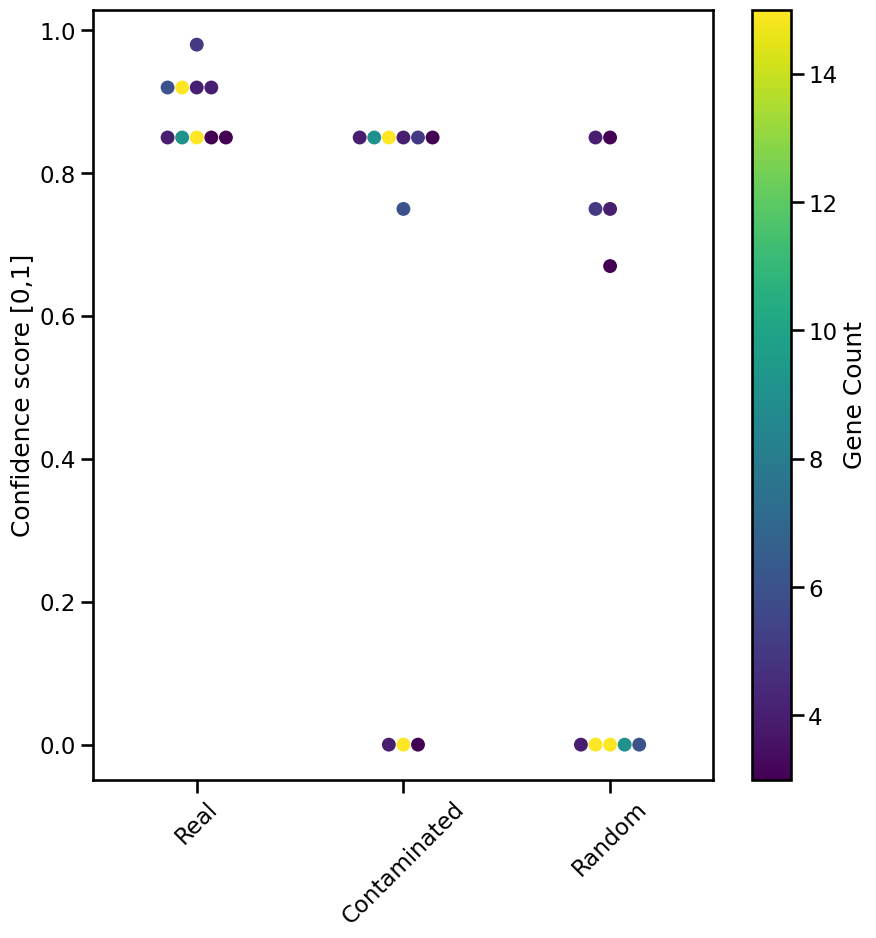

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context('talk')
plt.figure(figsize=(10, 10))
columns_score = [col for col in score_df.columns if col.endswith('Score')]

filtered_score_df = score_df[['GO', 'Gene_Count']+columns_score]
long_scores = filtered_score_df.melt(id_vars=['GO', 'Gene_Count'], var_name='Score Type', value_name='Score')

long_scores.head()
long_scores.Score = long_scores.Score.astype(float)
sns.swarmplot(x='Score Type', y='Score', data=long_scores, size=10, hue='Gene_Count', palette='viridis', edgecolor='none', legend=False, alpha=1)

# # Draw lines between points with the same 'GO'
# for name, group in long_scores.groupby('GO'):
#     if len(group) > 1:
#         plt.plot(group['Score Type'], group['Score'], marker='', color='grey', linewidth=1, alpha=0.5)

plt.xticks(ticks=np.arange(len(long_scores['Score Type'].unique())),labels=['Real', 'Contaminated', 'Random'], rotation=45)

plt.xlabel('')
plt.ylabel('Confidence score [0,1]')

# Create a colorbar for the continuous hue
norm = plt.Normalize(long_scores['Gene_Count'].min(), long_scores['Gene_Count'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Add the colorbar to the plot
plt.colorbar(sm, label='Gene Count')

plt.show()


In [ ]:
# test the script for batch run

input_file = 'data/GO_term_analysis/toy_example.csv'
config = './jsonFiles/GOLLMrun_config.json'
%run query_llm_for_analysis.py --input $input_file --start 0 --end 1 --config $config

## Checkout and combine the output from the batch run 

In [ ]:
from glob import glob
import pandas as pd
import json

### sanity check code along the way
processed_files = glob('data/GO_term_analysis/LLM_processed_selected_go_terms*.tsv')

for file in processed_files:
    df = pd.read_csv(file, sep='\t')
    df.set_index('GO', inplace=True)
    ranges = file.split('/')[-1].split('.')[0].split('_')[5:7]
    with open(f'data/GO_term_analysis/LLM_response_go_terms_{ranges[0]}_{ranges[1]}.json') as fp:
        llm_response_dict = json.load(fp)
    for go_term, row in df.iterrows():
        if llm_response_dict[go_term] == 'NO ANALYSIS':
            print(file.split('/')[-1])
            print(f'No analysis for {go_term}')
            continue
        else:
            llm_analysis = llm_response_dict[go_term].split('\n', 2)[2]
            if df.loc[go_term, 'LLM Analysis'] != llm_analysis:
                print(f'LLM analysis for {go_term} is different')
            
    df.reset_index(inplace=True)
#     # print(ranges)
    print(df.shape)

    
combined_df = pd.concat([pd.read_csv(f, sep = '\t') for f in processed_files])
print(combined_df.shape)
print('Any duplicated GO: ',combined_df['GO'].duplicated().sum())
print('Any NAs in the LLM res: ', combined_df['LLM Name'].isna().sum())
print('Any duplicated LLM analysis: ', combined_df['LLM Analysis'].duplicated(keep=False).sum())

combined_df.to_csv('data/GO_term_analysis/LLM_processed_selected_1000_go_terms.tsv', index=False, sep='\t')